Disclaimer: Kindly be aware that the questions and datasets featured in this tutorial were originally presented by [Ryan Abernathy in "An Introduction to Earth and Environmental Data Science"](https://earth-env-data-science.github.io/intro.html).

# More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

**Note**: "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'
%xmode Minimal

import warnings
warnings.filterwarnings('ignore')

Exception reporting mode: Minimal


![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

### Reproducing the SST curve from the figure above

We will use the `sst.mnmean.nc` file located at <https://psl.noaa.gov/repository/entry/get/sst.mnmean.nc?entryid=synth%3Ae570c8f9-ec09-4e89-93b4-babd5651e7a9%3AL25vYWEuZXJzc3QudjUvc3N0Lm1ubWVhbi5uYw%3D%3D>.


Let's fetch the data using the `pooch.retrieve()` function.

In [2]:
import pooch

url = 'https://psl.noaa.gov/repository/entry/get/sst.mnmean.nc?entryid=synth%3Ae570c8f9-ec09-4e89-93b4-babd5651e7a9%3AL25vYWEuZXJzc3QudjUvc3N0Lm1ubWVhbi5uYw%3D%3D'
fname = pooch.retrieve(url,
                       known_hash=None
                      )
print(fname)

/notebook_dir/writable-workspace/.home/.cache/pooch/b119eab09ce0983fc7bfb2546b45502c-sst.mnmean.nc


We can now load the datset using `Xarray`. We will drop the `time_bnds` variable and trim the data to 1950 onward.

In [3]:
data_file = '/notebook_dir/writable-workspace/.home/.cache/pooch/b119eab09ce0983fc7bfb2546b45502c-sst.mnmean.nc'

#open data using x_array
data = xr.open_dataset(data_file)

#slice the data from 
data = data.sel(time=slice('1950','2023')).drop_vars('time_bnds')
data

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 886)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-11-03

To recreate the plot, we'll require the following elements:

1. Data covering the Nino 3.4 region.
2. Monthly anomalies.
3. A curve representing the 3-month running mean.
4. Thresholds for identifying ENSO positive and negative phases.


Let's slice the data to focus on a specific region. We'll use the `slice()` function along with `sel()` to select the range for our study. It's crucial to note that when slicing, the order of the coordinates within the dataset matters. For instance, if latitude spans from $-60\ to\ 60$, specifying the slice should follow the order of the coordinates in the dataset $(20, 40)$ rather than $(40, 20)$, as the latter would only retrieve data at latitude $40$.

In [4]:
#slicing the el nino region

nino_region = data.sel(lon=slice(190, 240), lat=slice(5,-5))
nino_region

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 886)
Coordinates:
  * lat      (lat) float32 4.0 2.0 0.0 -2.0 -4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-11-03

Note, there are no odd values for `lat` in this dataset, in this case, the `sel()` function slices the highest value within the specified range. If we wanted to include data for $5^\circ S$ to $5^\circ N$ then we will need to specify the slice $(6,-6)$. Let's make this correction.

In [5]:
nino_region = data.sel(lon=slice(190, 240), lat=slice(6,-6))
nino_region

<xarray.Dataset>
Dimensions:  (lat: 7, lon: 26, time: 886)
Coordinates:
  * lat      (lat) float32 6.0 4.0 2.0 0.0 -2.0 -4.0 -6.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-11-03

Now that we've specified the region, we can compute the monthly anomaly. This involves calculating the mean over the spatial region and a spatiotemporal mean for the entire time series. Once these calculations are completed, the anomaly is determined by subtracting the spatiotemporal mean from the spatial mean.

In [6]:
#the mean over the entire area (spatially) 
nino_month_mean = nino_region.mean(dim=('lat','lon'))

#the spatial and temporal mean for the entire area
nino_region_mean = nino_region.mean()

#build the anomoly dataset
nino_anom = nino_month_mean - nino_region_mean




Let's utilize the `rolling()` function to compute the rolling mean. This function employs the `time` argument to define the grouping intervals. The monthly data, therefore we set `time=3` to indicate the rolling mean calculation across three-month periods.

In [7]:
#create a rolling 3 month mean dataset
rolling_mean = nino_anom.rolling(time=3, center=True).mean()

The last step in preparing the data for this figure involves defining positive and negative anomalies, allowing us to distinguish them with different colors. To achieve this, we employ the `np.where()` function to create filters or masks. It's worth noting that a similar approach can also be employed in `Pandas` for filtering data.

In [8]:
#define mask for positive and negative anomoly values
positive = nino_anom.sst.where(nino_anom.sst > 0)
negative = nino_anom.sst.where(nino_anom.sst < 0)


With the data prepared, we can not begin our plot.

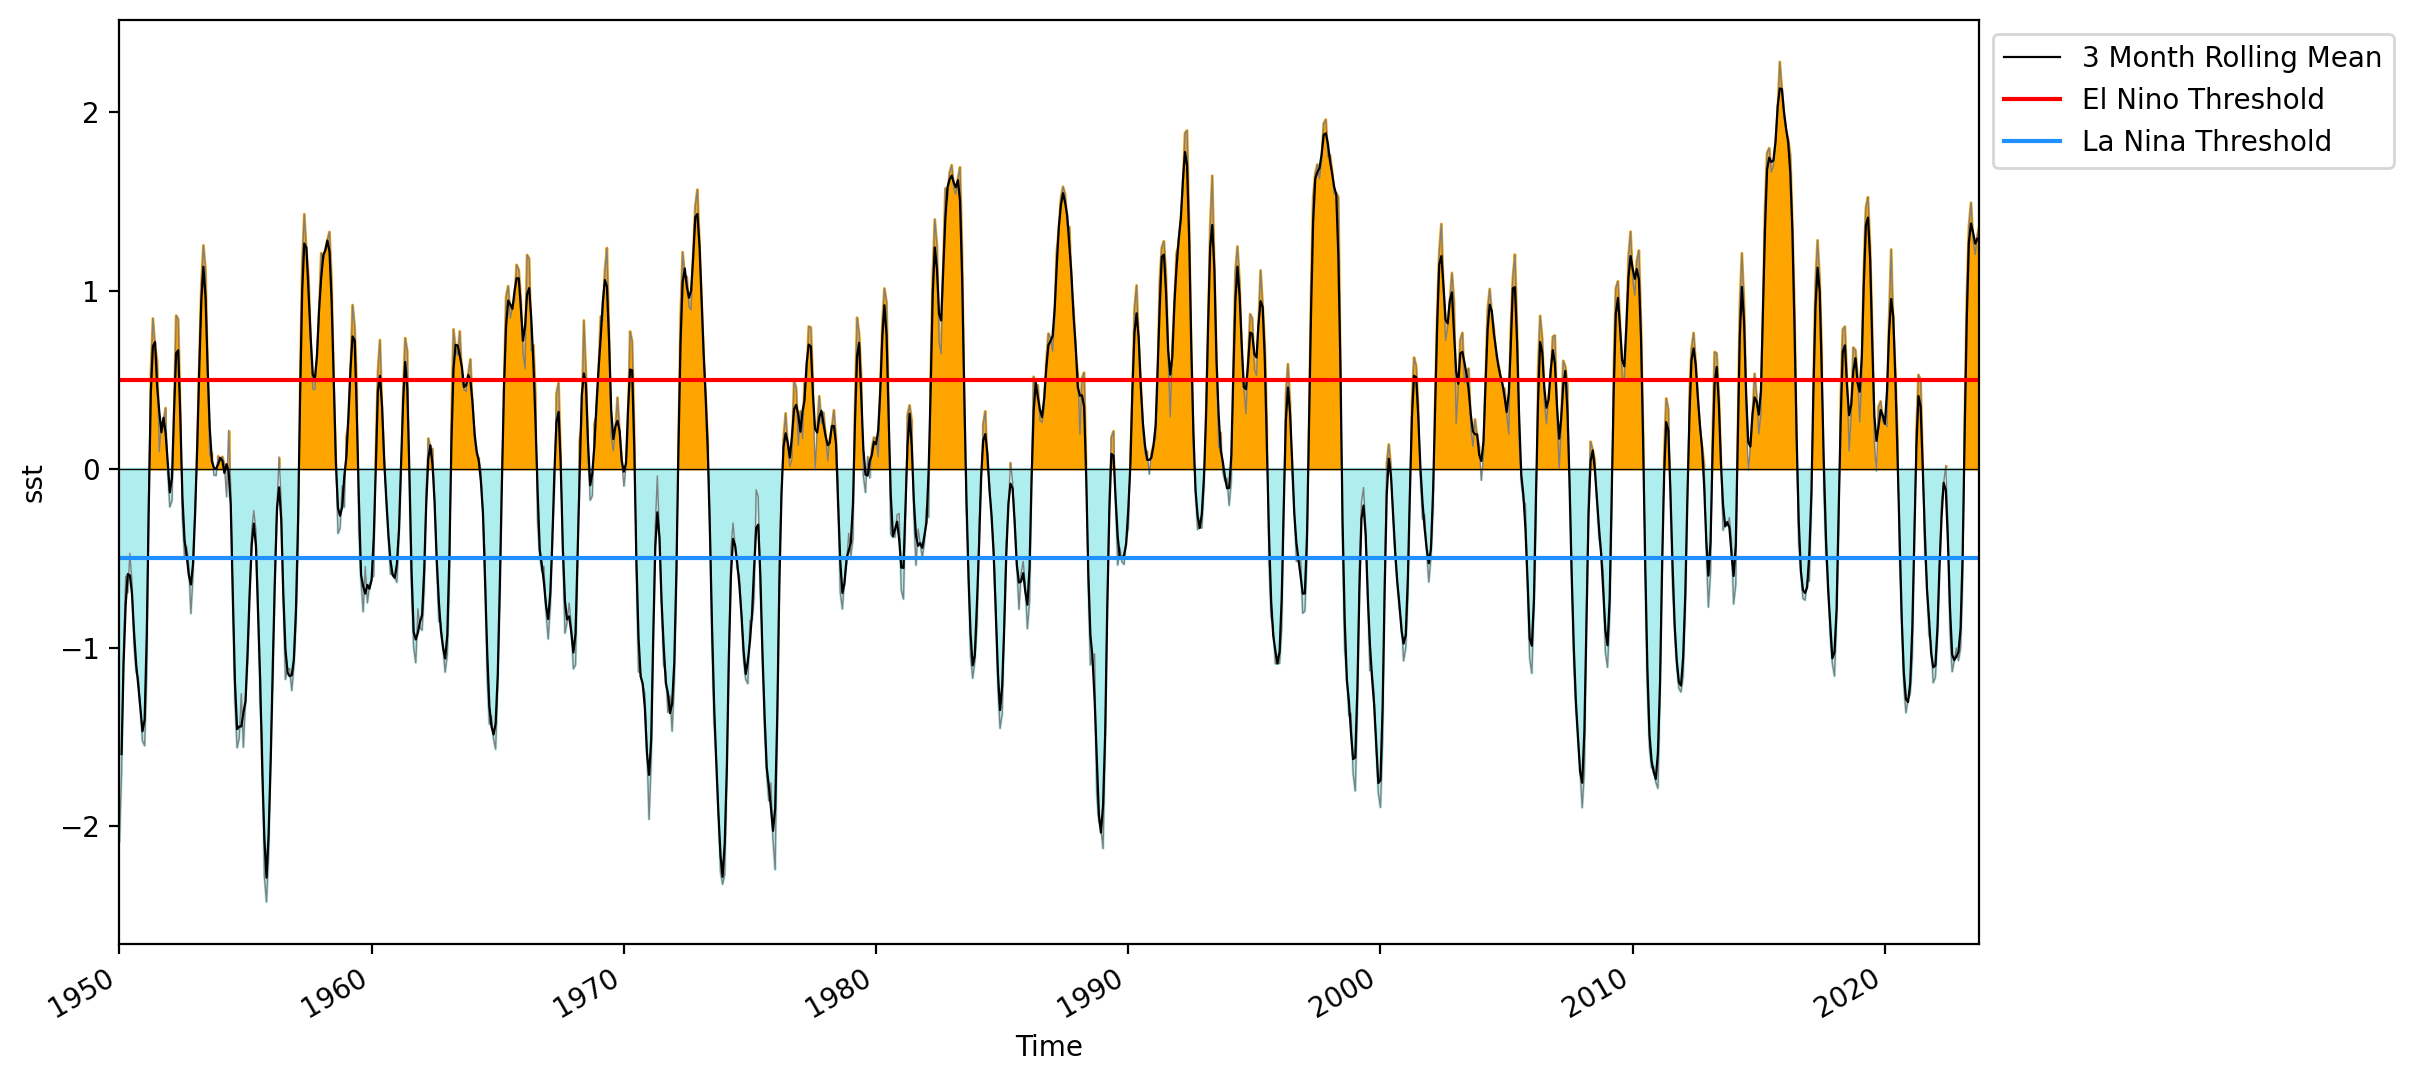

In [9]:
#plot the anomalies
nino_anom.sst.plot(linewidth=0.5, color='grey')

#fill the spaces between the 0 line and the anomaly values
plt.fill_between(nino_anom.time, 0, positive, color='orange')
plt.fill_between(nino_anom.time, 0, negative, color='paleturquoise')

#plot the rolling mean
rolling_mean.sst.plot(color='k', linewidth=0.8, label='3 Month Rolling Mean')

#create horizonal lines to demark 0, el nino and la nina thresholds
plt.axhline(0, linewidth=0.5, color='black')
plt.axhline(0.5, color='red', label='El Nino Threshold')
plt.axhline(-0.5, color='dodgerblue', label='La Nina Threshold')

#set the limits of the x axis
plt.xlim(nino_anom.time.min(), nino_anom.time.max())

#create a legend and place it outside of plot
plt.legend(bbox_to_anchor=(1,1))

#show plot
plt.show()

#### Code Explanation

We begin by plotting the anomalies onto the figure using the following code snippet:
```python
nino_anom.sst.plot(linewidth=0.5, color='grey')
```
Following this, we'll utilize `plt.fill_between()` to apply colors:
```python
plt.fill_between(nino_anom.time, 0, positive, color='orange')
plt.fill_between(nino_anom.time, 0, negative, color='paleturquoise')
```
Here, the x-axis represents time, while y1 is set as 0. The y2 parameter represents one of the previously created filter variables.

Now we can move on to plotting the 3 month running average and setting the upper and lower thresholds for specifying an ENSO event.
```python

rolling_mean.sst.plot(color='k', linewidth=0.8, label='3 Month Rolling Mean')

plt.axhline(0, linewidth=0.5, color='black')
plt.axhline(0.5, color='red', label='El Nino Threshold')
plt.axhline(-0.5, color='dodgerblue', label='La Nina Threshold')
```

### Calculating a boolean timeseries representing the positive / negative ENSO phases

In this method, we'll construct a new boolean variable that indicates the presence of a positive ENSO (1), negative ENSO (0), or neither (null).

In [10]:
#create an array to hold the bolean values
nino_signature = []

#iterate through the temp
for sst in rolling_mean.sst:
    # >0.5 Nino
    if sst > 0.5:
        nino_signature.append(True)
    # < -0.5 nina    
    elif sst < -0.5:
        nino_signature.append(False)
    else:
        nino_signature.append(np.nan)

#make el nino array
elnino = xr.DataArray(nino_signature, dims='time')

#add the new array to the current dataset
rolling_mean = rolling_mean.assign(el_nino=elnino)

#show dataset
rolling_mean
  

<xarray.Dataset>
Dimensions:  (time: 886)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-10-01
Data variables:
    sst      (time) float32 nan -1.596 -1.1 -0.7636 ... 1.325 1.263 1.29 nan
    el_nino  (time) float64 nan 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 nan

Pause for a moment to reflect on why we opted for the rolling mean of the anomaly instead of the anomaly itself.

Now, let's generate a mask to distinguish between the various phases of ENSO.

In [11]:
# Create masks for El Nino and la Nina
nino_mask = rolling_mean.el_nino == True
nina_mask = rolling_mean.el_nino == False


Now, it's time to create the visualization. We'll utilize `matplotlib.pyplot.vlines()` to plot vertical lines. The color of these lines will correspond to the ENSO phase, and their thickness will represent the duration of the respective ENSO event.

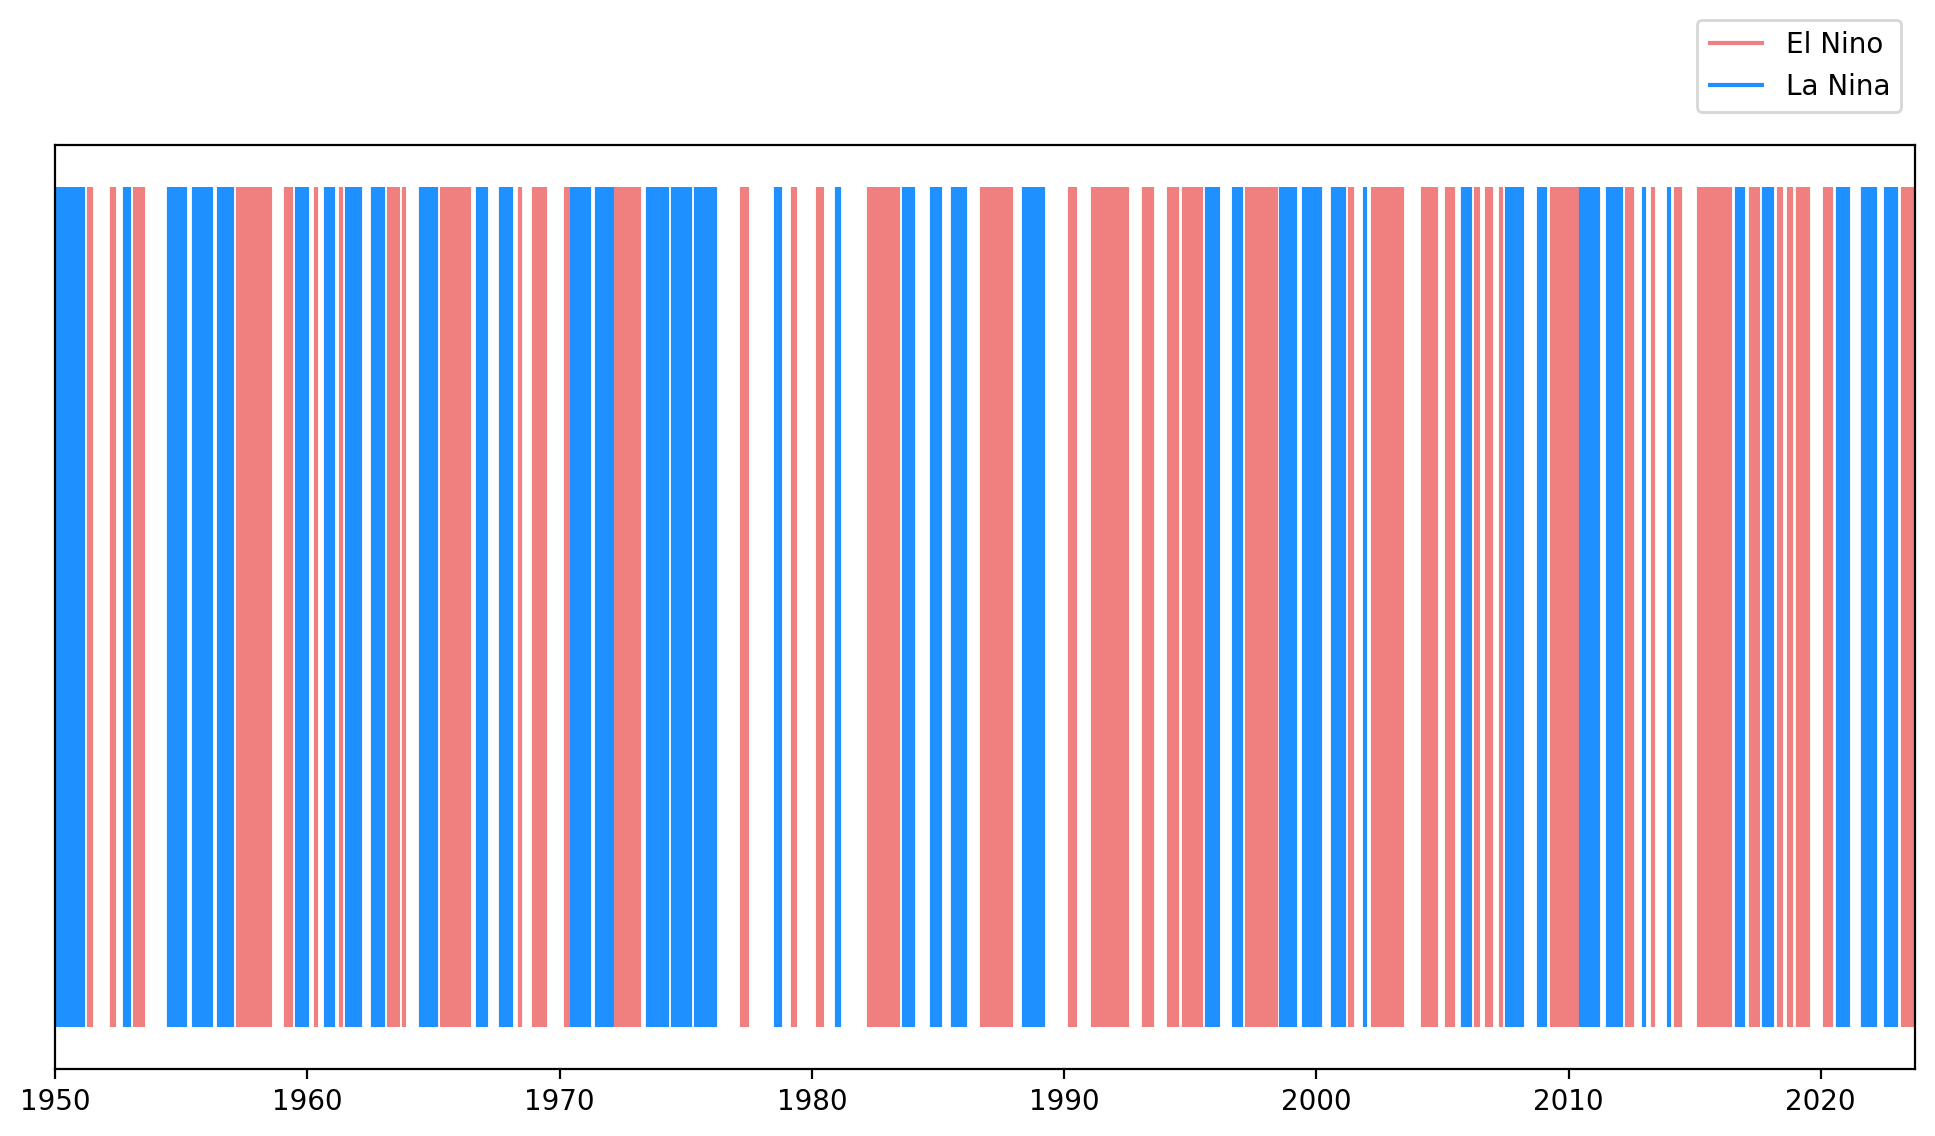

In [12]:
# Plot vertical lines using plt.vlines() and set thickness of lines to time min and max
plt.vlines(x=nino_anom.time.where(nino_mask), ymin=0, ymax=1, color='lightcoral', label='El Nino')
plt.vlines(x=nino_anom.time.where(nina_mask), ymin=0, ymax=1, color='dodgerblue', label='La Nina')

#set the limits of the x axis
plt.xlim(nino_anom.time.min(), nino_anom.time.max())


#create a legend and place it outside of plot
plt.legend(bbox_to_anchor=(1,1.15))

# Remove y-axis ticks and labels
plt.yticks([])

#show plot
plt.show()

#### Code Explanation

Using `x=nino_anom.time.where(nino_mask)` in the `vlines()` function, we plot vertical lines wherever the filter (mask) holds true. This setup allows the width of the lines to represent the duration of an event.
<br>
<br>
<br>



### Composites of SST anomaly for the positive and negative ENSO regimes over the tropical Pacific

We will use `pcolormesh` to create the visualization. Keep in mind that this plot requires a $2D$ array.

Let's widen our view by taking a larger slice of the Pacific.

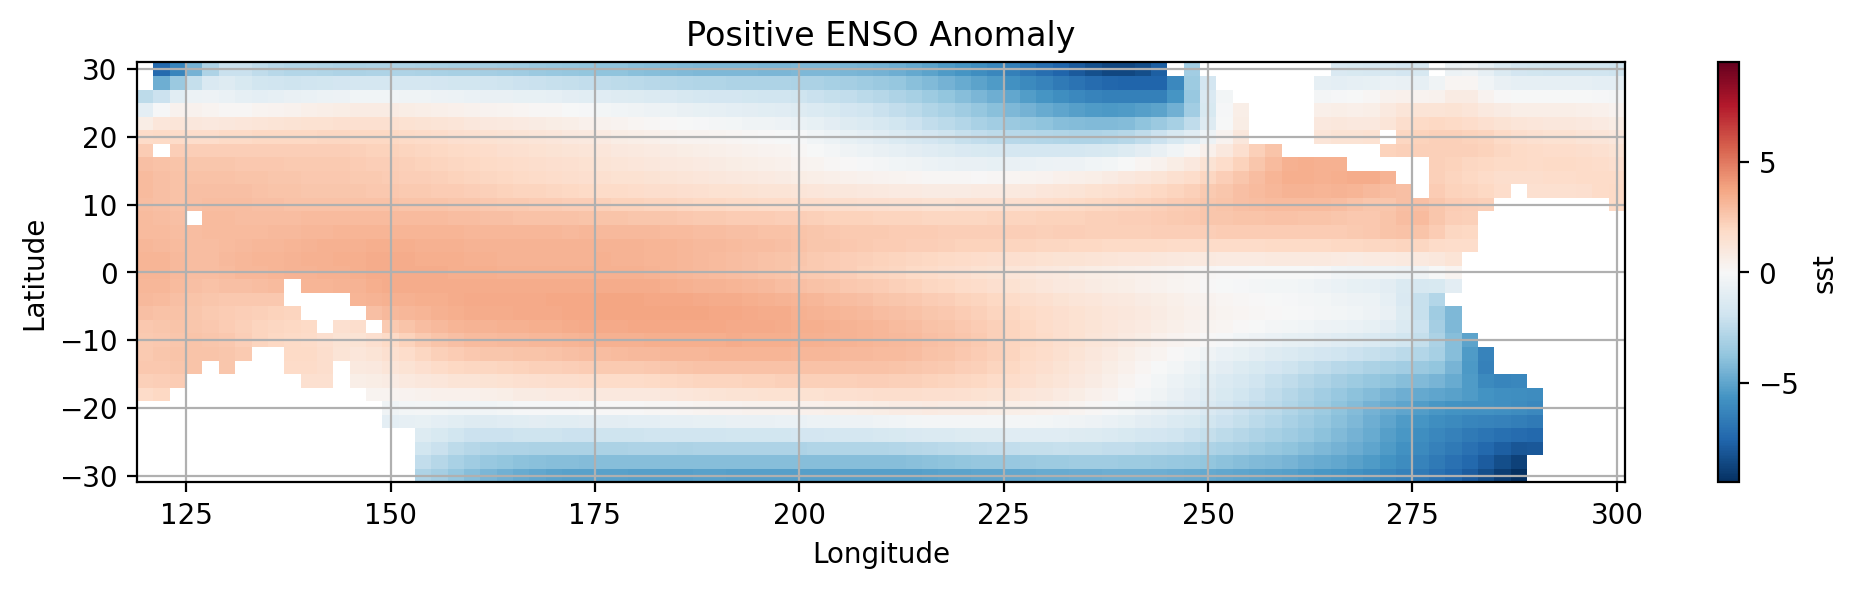

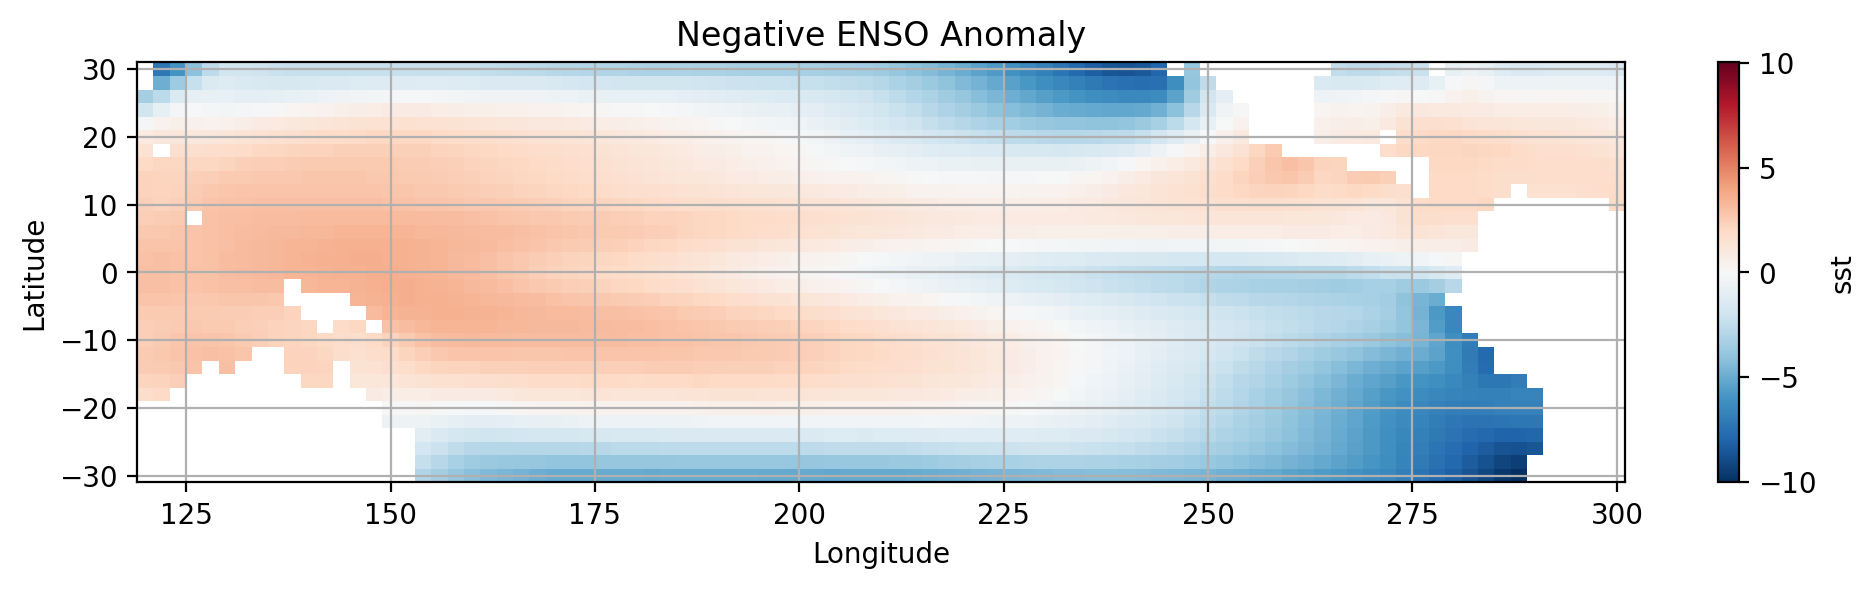

In [13]:
#select data for the tropical pacific
pacific_tropics = data.sel(lat=slice(30,-30), lon=slice(120,300))



#SUBPLOT 1
plt.subplot(2,1,1)

#Create anomaly dataset for positive ENSO
elnino_anom = pacific_tropics.where(nino_mask).mean(dim='time') - pacific_tropics.mean()

# Plot sst using pcolormesh (You can also use contourf())
elnino_anom.sst.plot.pcolormesh(x='lon',y='lat')

# Label the figure
plt.title('Positive ENSO Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


#SUBPLOT 2
plt.subplot(2,1,2)

# Create anomaly dataset for negative ENSO
lanina_anom = pacific_tropics.where(nina_mask).mean(dim='time') - pacific_tropics.mean()

# plot using pcolormesh()
lanina_anom.sst.plot.pcolormesh(x='lon',y='lat')

# Label the figure
plt.title('Negative ENSO Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

# show figure
plt.show()

How do the two plots compare? 
<br>
<br>
<br>

### Calculating the composite of preciptiation for positive and negative ENSO phases.

We can extend what we have done above to include the precipitation anomaly present during different ENSO phases. Let's import the new dataset.

In [14]:
import pandas as pd

url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time', 'Y':'lat', 'X': 'lon'})
dsp.load()

<xarray.Dataset>
Dimensions:  (time: 361, lat: 72, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1990-01-01
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    prcp     (time, lat, lon) float32 nan nan nan ... 0.07234 0.06634 0.06526
Attributes:
    Conventions:  IRIDL

Let's slice the precipipation dataset over the study region.

In [15]:
dsp_tropical_pacific = dsp.sel(lat=slice(30,-30), lon=slice(120,300))
dsp_tropical_pacific

<xarray.Dataset>
Dimensions:  (time: 361, lat: 24, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1990-01-01
  * lat      (lat) float32 28.75 26.25 23.75 21.25 ... -23.75 -26.25 -28.75
  * lon      (lon) float32 121.2 123.8 126.2 128.8 ... 291.2 293.8 296.2 298.8
Data variables:
    prcp     (time, lat, lon) float32 3.215 2.923 2.95 ... 1.571 2.07 3.386
Attributes:
    Conventions:  IRIDL

As you can see this new dataset started from Jan 1 1960 and ends at Jan 1 1990. We will need to restrict our SST data to the same timeframe.

Now plotting the <u>difference between the time-mean</u> of `prcp` during positive and negative ENSO phases.

In [16]:
#create dataset for time frame
precip_sst = data.sel(time=slice(dsp.time.min(), dsp.time.max()))
precip_sst

#anomoly for time period
updated_rolling_mean = rolling_mean.sel(time=slice(dsp.time.min(), dsp.time.max()))
updated_rolling_mean

<xarray.Dataset>
Dimensions:  (time: 361)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1990-01-01
Data variables:
    sst      (time) float32 -0.62 -0.3865 -0.001988 ... -0.4822 -0.4196 -0.225
    el_nino  (time) float64 0.0 nan nan nan 1.0 nan ... nan nan nan nan nan nan

A new dataset also calls for a new filter(mask).

In [17]:
# Create masks for El Nino and la Nina
prcp_nino_mask = updated_rolling_mean.el_nino == True
prcp_nina_mask = updated_rolling_mean.el_nino == False

All that is left is to calauate the regional temporal mean.

In [18]:
#calculate the means
total_precip_mean = dsp_tropical_pacific.mean(dim='time')
total_precip_mean


<xarray.Dataset>
Dimensions:  (lat: 24, lon: 72)
Coordinates:
  * lat      (lat) float32 28.75 26.25 23.75 21.25 ... -23.75 -26.25 -28.75
  * lon      (lon) float32 121.2 123.8 126.2 128.8 ... 291.2 293.8 296.2 298.8
Data variables:
    prcp     (lat, lon) float32 4.89 4.24 5.073 5.52 ... 1.214 1.923 2.805

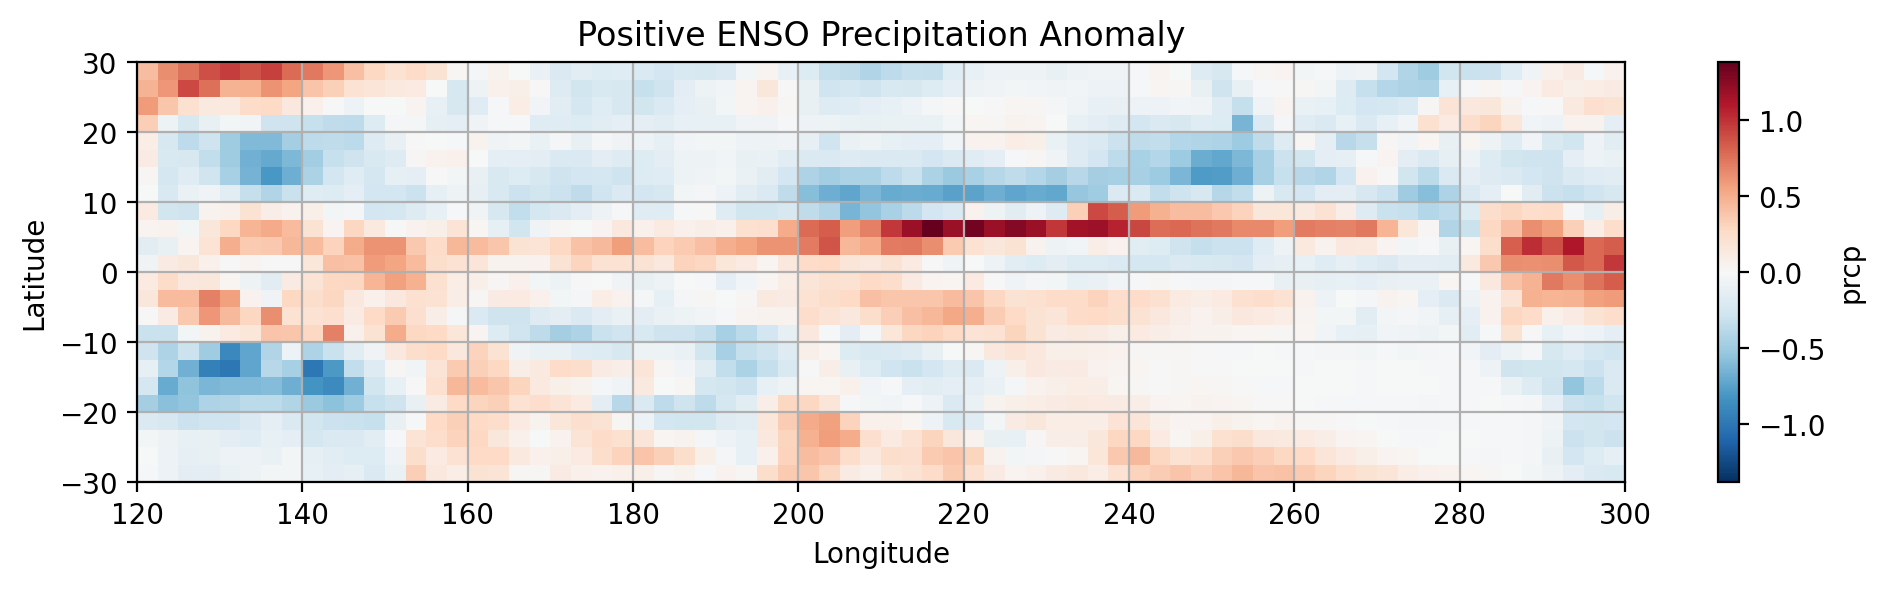

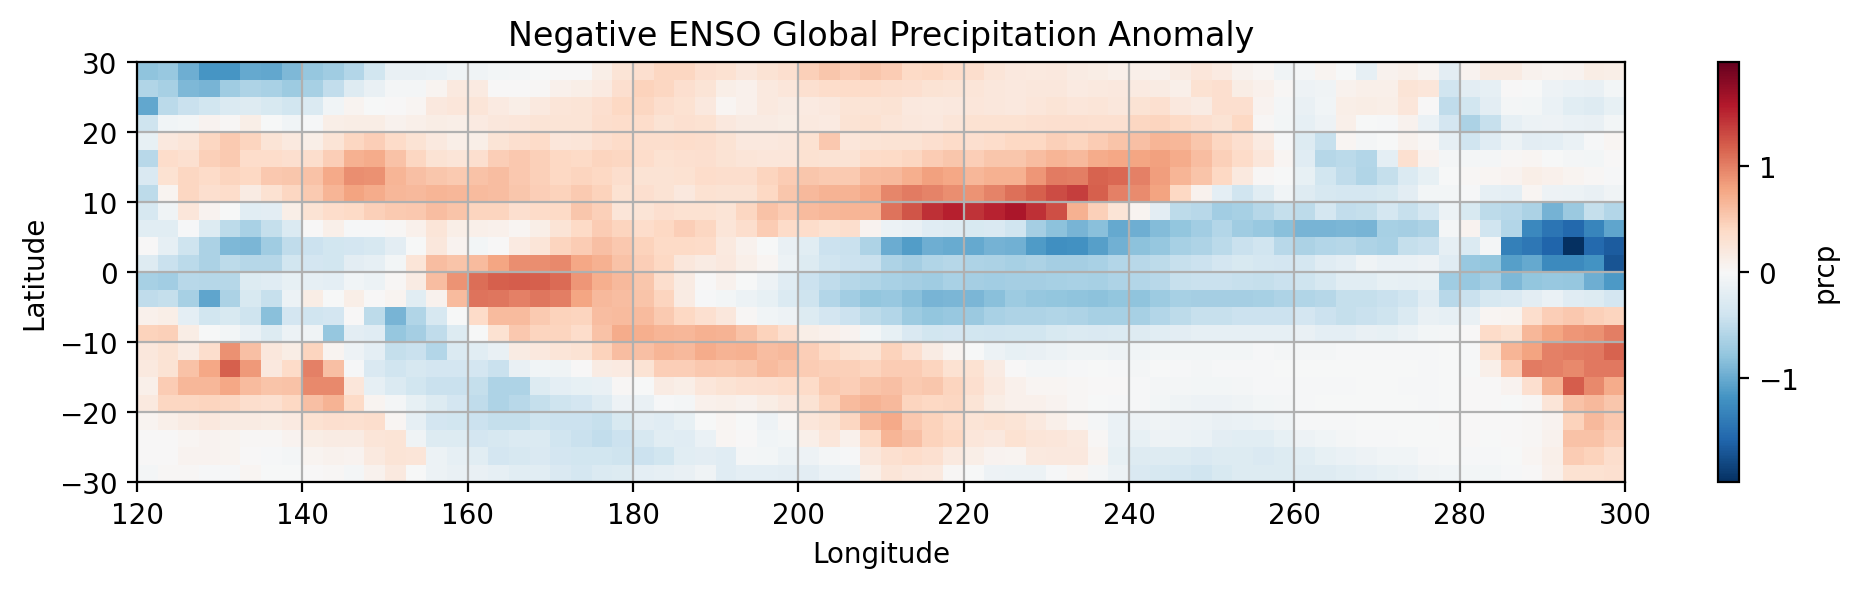

In [25]:
#Positive ENSO PRCP
POS_ENSO_PRCP = dsp_tropical_pacific.where(prcp_nino_mask).mean(dim='time') - total_precip_mean

#SUBPLOT 1
plt.subplot(2,1,1)
POS_ENSO_PRCP.prcp.plot.pcolormesh()


# Label the figure
plt.title('Positive ENSO Precipitation Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(which='major')

# show figure
plt.show()



# Negative ENSO PRCP
NEG_ENSO_PRCP = dsp_tropical_pacific.where(prcp_nina_mask).mean(dim='time') - total_precip_mean

#SUBPLOT 2
plt.subplot(2,1,2)
NEG_ENSO_PRCP.prcp.plot.pcolormesh()


# Label the figure
plt.title('Negative ENSO Global Precipitation Anomaly')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(which='major')

# show figure
plt.show()

Note the differences in the distribution of precipitation between the phases of ENSO.

#### Final Thoughts
By this point, you have been introduced to essential Python libraries and packages commonly employed in climate data analysis. Feel free to engage with the presented questions independently, as my solutions represent just one approach to these challenges.

In your exploration, we covered foundational tools such as NumPy and Matplotlib for scientific computation and graphical representation. Subsequently, we introduced Pandas and Xarray for effective data manipulation, forming the groundwork for numerous packages and frameworks in your research journey. Additionally, you gained insights into the complexities involved in computations on a spherical surface, particularly regarding variables with components in square meters, necessitating specific scaling based on each location's position on the Earth's surface.

At this fundamental stage, you should now possess an intuitive understanding of working with geoscience data in its basic form.

Our next focus is on enhancing the visual appeal and interpretability of our plots by incorporating maps and topographical information using Python. This skillset will then be extended to working with global climate models. As you progress, it is highly recommended to revisit the worked examples and explore the text authored by [Ryan Abernathy - An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html) and the contributions of [Michael Morris - UTCDW Guidebook](https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/README.html).